In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from PIL import Image

In [31]:
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 3e-4
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATIENCE = 5  # For early stopping

In [32]:
print(f"Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

Using device: cuda
CUDA device: Tesla P100-PCIE-16GB
CUDA version: 12.3


In [33]:
Root_dir = "/kaggle/input/new-plant-diseases-datasetaugmented/archive_cleaned/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = Root_dir + "/train"
valid_dir = Root_dir + "/valid"
test_dir = "/kaggle/input/new-plant-diseases-datasetaugmented/archive_cleaned/test/test"

In [34]:
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Valid directory exists: {os.path.exists(valid_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")

if os.path.exists(train_dir):
    print(f"Number of files in train: {len(os.listdir(train_dir))}")
if os.path.exists(valid_dir):
    print(f"Number of files in valid: {len(os.listdir(valid_dir))}")
if os.path.exists(test_dir):
    print(f"Number of files in test: {len(os.listdir(test_dir))}")

Train directory exists: True
Valid directory exists: True
Test directory exists: True
Number of files in train: 38
Number of files in valid: 38
Number of files in test: 33


In [35]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [36]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform)

In [37]:
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(test_dir))
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.test_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]

In [38]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataset = TestDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"\nDataset sizes:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Dataset sizes:
Training samples: 70295
Validation samples: 17572
Test samples: 33


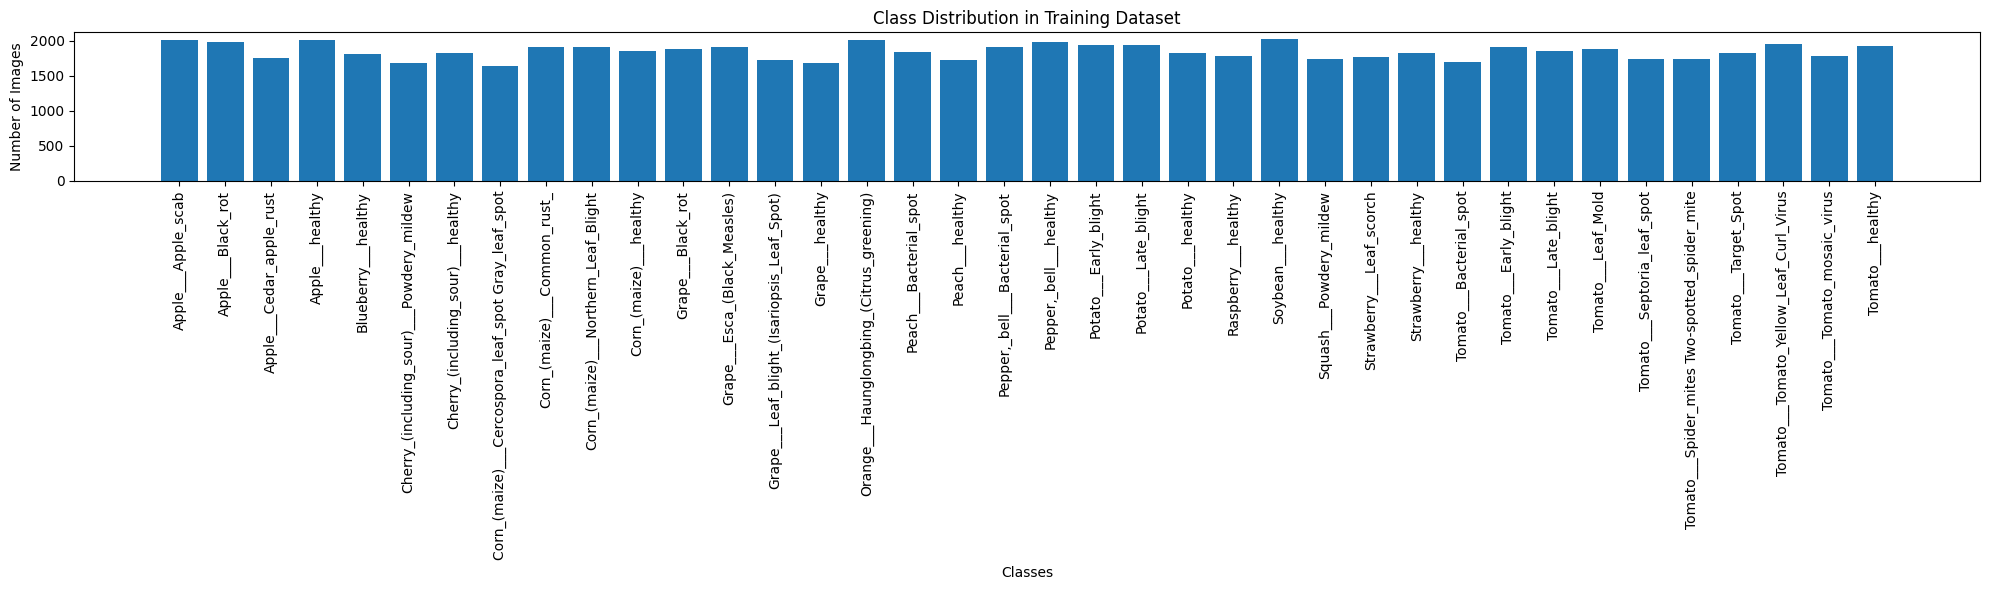

In [39]:
def plot_class_distribution():
    class_names = train_dataset.classes
    class_counts = [0] * len(class_names)
    for _, label in train_dataset.samples:
        class_counts[label] += 1
    
    plt.figure(figsize=(20, 6))
    plt.bar(class_names, class_counts)
    plt.xticks(rotation=90)
    plt.title('Class Distribution in Training Dataset')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.tight_layout()
    plt.show()

plot_class_distribution()

In [40]:
class EarlyStopping:
    def __init__(self, patience=PATIENCE, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [41]:
# Model Definition
class PlantDiseaseModel(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseModel, self).__init__()
        self.model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Freeze early layers
        for param in list(self.model.parameters())[:-20]:
            param.requires_grad = False
            
        # Modify classifier
        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(num_ftrs, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

In [42]:
# Training Function
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    early_stopping = EarlyStopping()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = running_loss / len(valid_loader)
        val_acc = 100. * correct / total
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        
        # Step the scheduler
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.2f}%')
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), '/kaggle/working/plant_disease_model.pth')
            print(f"Saved new best model with validation accuracy: {val_acc:.2f}%")
        
        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    return train_losses, valid_losses, train_accs, valid_accs

In [43]:
# Plot Training Results
def plot_training_results(train_losses, valid_losses, train_accs, valid_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(valid_losses, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracies
    ax2.plot(train_accs, label='Training Accuracy')
    ax2.plot(valid_accs, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

Starting Training Phase...

Starting model training...


Epoch 1/20: 100%|██████████| 2197/2197 [02:07<00:00, 17.19it/s]


Epoch 1/20:
Train Loss: 0.2860, Train Acc: 93.14%
Valid Loss: 0.0467, Valid Acc: 98.49%
Saved new best model with validation accuracy: 98.49%


Epoch 2/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.75it/s]


Epoch 2/20:
Train Loss: 0.0583, Train Acc: 98.19%
Valid Loss: 0.0303, Valid Acc: 99.08%
Saved new best model with validation accuracy: 99.08%


Epoch 3/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.75it/s]


Epoch 3/20:
Train Loss: 0.0375, Train Acc: 98.81%
Valid Loss: 0.0217, Valid Acc: 99.27%
Saved new best model with validation accuracy: 99.27%


Epoch 4/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.77it/s]


Epoch 4/20:
Train Loss: 0.0282, Train Acc: 99.08%
Valid Loss: 0.0223, Valid Acc: 99.26%


Epoch 5/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.89it/s]


Epoch 5/20:
Train Loss: 0.0233, Train Acc: 99.28%
Valid Loss: 0.0187, Valid Acc: 99.39%
Saved new best model with validation accuracy: 99.39%


Epoch 6/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.88it/s]


Epoch 6/20:
Train Loss: 0.0188, Train Acc: 99.37%
Valid Loss: 0.0198, Valid Acc: 99.40%
Saved new best model with validation accuracy: 99.40%


Epoch 7/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.88it/s]


Epoch 7/20:
Train Loss: 0.0161, Train Acc: 99.49%
Valid Loss: 0.0219, Valid Acc: 99.32%


Epoch 8/20: 100%|██████████| 2197/2197 [01:44<00:00, 20.94it/s]


Epoch 8/20:
Train Loss: 0.0152, Train Acc: 99.51%
Valid Loss: 0.0172, Valid Acc: 99.44%
Saved new best model with validation accuracy: 99.44%


Epoch 9/20: 100%|██████████| 2197/2197 [01:44<00:00, 21.08it/s]


Epoch 9/20:
Train Loss: 0.0145, Train Acc: 99.55%
Valid Loss: 0.0160, Valid Acc: 99.44%
Saved new best model with validation accuracy: 99.44%


Epoch 10/20: 100%|██████████| 2197/2197 [01:44<00:00, 21.03it/s]


Epoch 10/20:
Train Loss: 0.0114, Train Acc: 99.64%
Valid Loss: 0.0181, Valid Acc: 99.47%
Saved new best model with validation accuracy: 99.47%


Epoch 11/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.83it/s]


Epoch 11/20:
Train Loss: 0.0115, Train Acc: 99.63%
Valid Loss: 0.0170, Valid Acc: 99.45%


Epoch 12/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.88it/s]


Epoch 12/20:
Train Loss: 0.0108, Train Acc: 99.65%
Valid Loss: 0.0220, Valid Acc: 99.41%


Epoch 13/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.80it/s]


Epoch 13/20:
Train Loss: 0.0095, Train Acc: 99.69%
Valid Loss: 0.0172, Valid Acc: 99.52%
Saved new best model with validation accuracy: 99.52%


Epoch 14/20: 100%|██████████| 2197/2197 [01:46<00:00, 20.71it/s]


Epoch 14/20:
Train Loss: 0.0058, Train Acc: 99.82%
Valid Loss: 0.0122, Valid Acc: 99.62%
Saved new best model with validation accuracy: 99.62%


Epoch 15/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.76it/s]


Epoch 15/20:
Train Loss: 0.0040, Train Acc: 99.88%
Valid Loss: 0.0116, Valid Acc: 99.66%
Saved new best model with validation accuracy: 99.66%


Epoch 16/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.83it/s]


Epoch 16/20:
Train Loss: 0.0035, Train Acc: 99.89%
Valid Loss: 0.0105, Valid Acc: 99.68%
Saved new best model with validation accuracy: 99.68%


Epoch 17/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.73it/s]


Epoch 17/20:
Train Loss: 0.0031, Train Acc: 99.90%
Valid Loss: 0.0092, Valid Acc: 99.73%
Saved new best model with validation accuracy: 99.73%


Epoch 18/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.80it/s]


Epoch 18/20:
Train Loss: 0.0024, Train Acc: 99.94%
Valid Loss: 0.0109, Valid Acc: 99.65%


Epoch 19/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.78it/s]


Epoch 19/20:
Train Loss: 0.0024, Train Acc: 99.93%
Valid Loss: 0.0111, Valid Acc: 99.67%


Epoch 20/20: 100%|██████████| 2197/2197 [01:45<00:00, 20.88it/s]


Epoch 20/20:
Train Loss: 0.0022, Train Acc: 99.94%
Valid Loss: 0.0114, Valid Acc: 99.68%


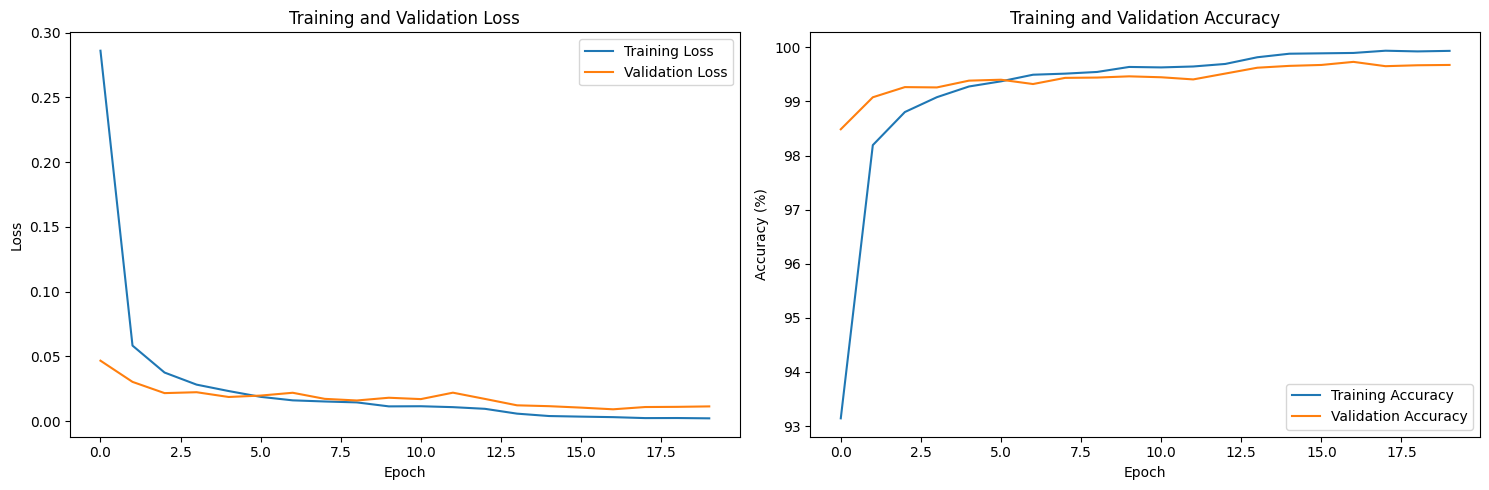

In [44]:
# Function to test the model and make predictions
def test_model(model, test_loader, class_names):
    model.eval()
    predictions = []
    filenames = []
    
    with torch.no_grad():
        for inputs, fname in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            predictions.append(class_names[predicted.item()])
            filenames.append(fname[0])
    
    return pd.DataFrame({
        'filename': filenames,
        'predicted_class': predictions
    })

# Training Phase
print("Starting Training Phase...")

# Initialize model
num_classes = len(train_dataset.classes)
model = PlantDiseaseModel(num_classes).to(DEVICE)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1, 
    patience=3
)

# Train model
print("\nStarting model training...")
train_losses, valid_losses, train_accs, valid_accs = train_model(
    model, criterion, optimizer, scheduler, NUM_EPOCHS
)

# Plot results
plot_training_results(train_losses, valid_losses, train_accs, valid_accs)

In [45]:
# Testing Phase
print("\nStarting Testing Phase...")
predictions_df = test_model(model, test_loader, train_dataset.classes)

# Print test results summary
print("\nTest Predictions Summary:")
print(f"Total images tested: {len(predictions_df)}")
print("\nSample predictions:")
print(predictions_df.head())

# Save predictions
predictions_df.to_csv('/kaggle/working/test_predictions.csv', index=False)
print("\nPredictions saved to: /kaggle/working/test_predictions.csv")


Starting Testing Phase...


Testing: 100%|██████████| 33/33 [00:00<00:00, 57.47it/s]


Test Predictions Summary:
Total images tested: 33

Sample predictions:
              filename           predicted_class
0  AppleCedarRust1.JPG  Apple___Cedar_apple_rust
1  AppleCedarRust2.JPG  Apple___Cedar_apple_rust
2  AppleCedarRust3.JPG  Apple___Cedar_apple_rust
3  AppleCedarRust4.JPG  Apple___Cedar_apple_rust
4       AppleScab1.JPG        Apple___Apple_scab

Predictions saved to: /kaggle/working/test_predictions.csv
